# Plot

### プルリクエストの特徴量を集計

In [15]:
import numpy as np
import pandas as pd


def get_stats(df, feature):
    values = df[feature]
    return pd.DataFrame(
        data=[
            {
                "mean": values.mean(),
                "Q1": values.quantile(0.25),
                "median": values.median(),
                "Q3": values.quantile(0.75),
            }
        ],
        index=[feature],
    )


NUMERIC_COLUMNS = (
    "age",
    "#added",
    "#deleted",
    "#commits",
    "#files",
    "#comments",
    "#review_comments",
    "#approvals",
    "#changes_requested",
)
BOOLEAN_COLUMNS = (
    "intra_branch",
    "fix",
    "test",
)

# プルリクエストの特徴量データを読み込む
df = pd.read_csv("data/pull_request_features.csv")
df = df[df["bot"] == False]
df = df[df["code_change"] == True]

# 不具合混入の有無でデータを分割
buggy_df = df[df["buggy"] == True]
clean_df = df[df["buggy"] == False]

print(f"buggy: {len(buggy_df)}")
print(f"clean: {len(clean_df)}")
print(f"total: {len(df)}")

# ==============================================
# 数値特徴量に対して，統計量を計算
# ==============================================
buggy_stats_df = pd.DataFrame()
clean_stats_df = pd.DataFrame()
for feature in NUMERIC_COLUMNS:
    buggy_values = buggy_df[feature]
    clean_values = clean_df[feature]

    buggy_stats_df = pd.concat([buggy_stats_df, get_stats(buggy_df, feature)])
    clean_stats_df = pd.concat([clean_stats_df, get_stats(clean_df, feature)])


# ==============================================
# 真偽値特徴量に対して，クロス集計表を作成
# ==============================================
cross_df = pd.DataFrame()
for feature in BOOLEAN_COLUMNS:
    buggy_values = buggy_df[feature]
    clean_values = clean_df[feature]

    cross_df = pd.concat(
        [
            cross_df,
            pd.DataFrame(
                data=[
                    {
                        "feature": feature,
                        "bool": True,
                        "buggy": buggy_values.sum(),
                        "clean": clean_values.sum(),
                    },
                    {
                        "feature": feature,
                        "bool": False,
                        "buggy": len(buggy_values) - buggy_values.sum(),
                        "clean": len(clean_values) - clean_values.sum(),
                    },
                ],
                index=[feature + "_True", feature + "_False"],
            ),
        ]
    )
cross_df["buggy_rate"] = (
    cross_df["buggy"] / (cross_df["buggy"] + cross_df["clean"]) * 100
).apply(lambda x: f"({x:.2f}%)")
cross_df["clean_rate"] = (
    cross_df["clean"] / (cross_df["buggy"] + cross_df["clean"]) * 100
).apply(lambda x: f"({x:.2f}%)")
cross_df = cross_df[["feature", "bool", "buggy", "buggy_rate", "clean", "clean_rate"]]

# 結果を表示

print(buggy_stats_df.to_latex(float_format="%.2f", escape=True))
print(clean_stats_df.to_latex(float_format="%.2f", escape=True))
print(cross_df.to_latex(index=False, float_format="%.2f", escape=True))

buggy: 887
clean: 4044
total: 4931
\begin{tabular}{lrrrr}
\toprule
 & mean & Q1 & median & Q3 \\
\midrule
age & 24383.85 & 1355.93 & 5404.62 & 17466.65 \\
\#added & 2424.17 & 61.00 & 244.00 & 998.50 \\
\#deleted & 794.20 & 9.00 & 46.00 & 282.00 \\
\#commits & 6.73 & 1.00 & 2.00 & 5.00 \\
\#files & 32.66 & 3.00 & 9.00 & 25.00 \\
\#comments & 3.93 & 0.00 & 1.00 & 4.00 \\
\#review\_comments & 2.41 & 0.00 & 0.00 & 0.00 \\
\#approvals & 0.21 & 0.00 & 0.00 & 0.00 \\
\#changes\_requested & 0.07 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
 & mean & Q1 & median & Q3 \\
\midrule
age & 23863.10 & 1017.93 & 4016.56 & 13276.84 \\
\#added & 566.39 & 9.00 & 49.00 & 202.00 \\
\#deleted & 419.23 & 2.00 & 10.00 & 50.00 \\
\#commits & 2.63 & 1.00 & 1.00 & 2.00 \\
\#files & 13.26 & 1.00 & 3.00 & 8.00 \\
\#comments & 2.61 & 0.00 & 1.00 & 3.00 \\
\#review\_comments & 1.03 & 0.00 & 0.00 & 0.00 \\
\#approvals & 0.26 & 0.00 & 0.00 & 0.00 \\
\#changes\_requested & 0.03 & 0

### プルリクエスト毎に特徴量をヒストグラムにプロット

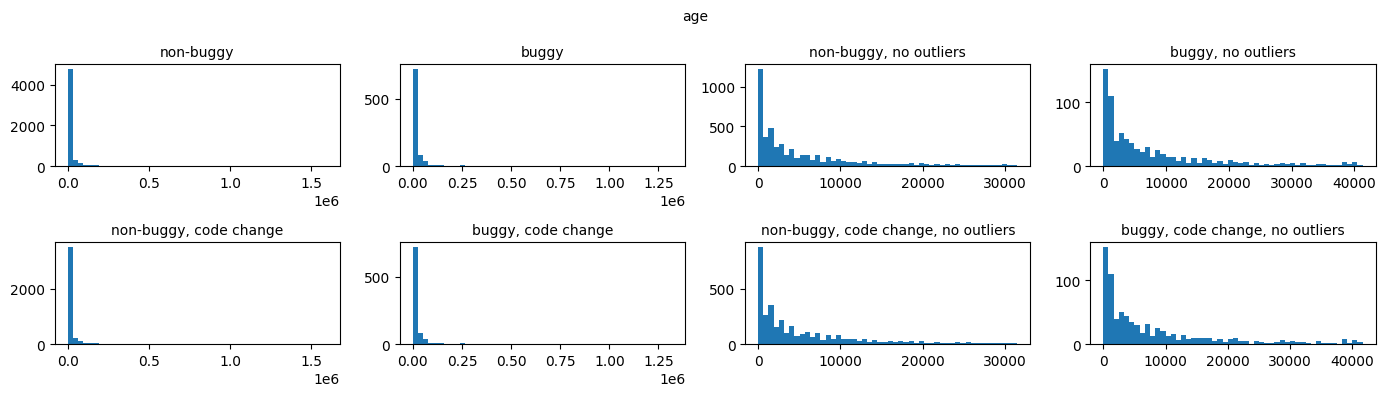

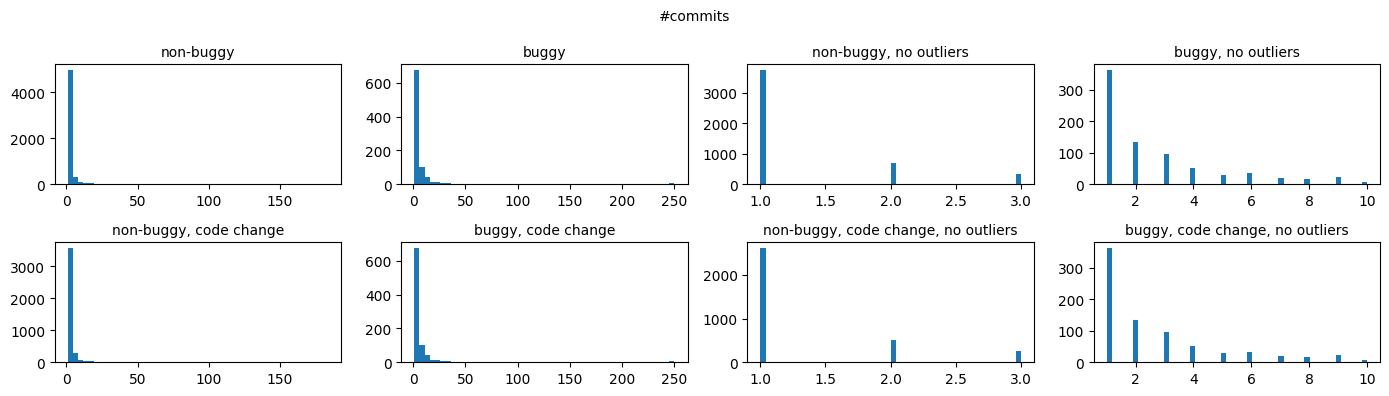

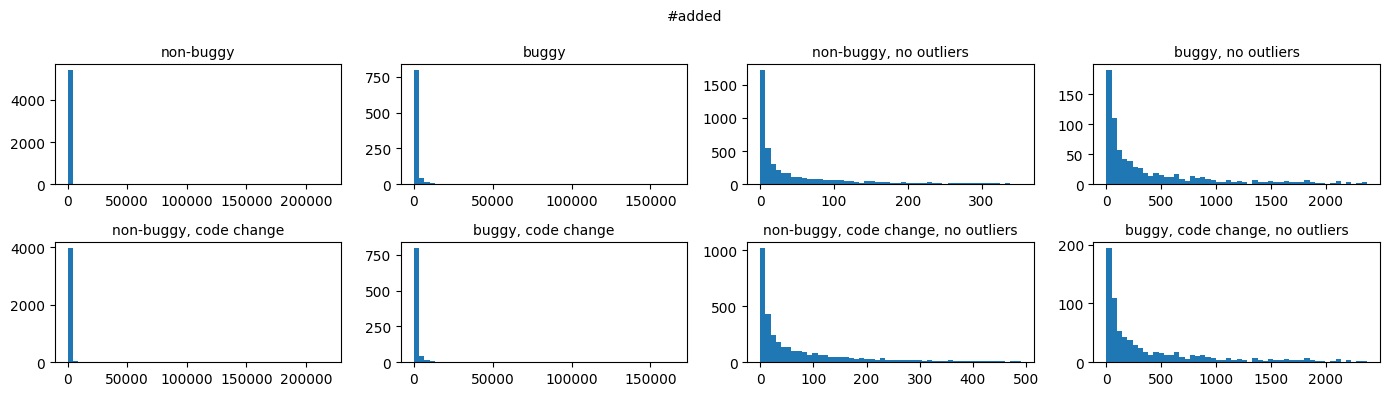

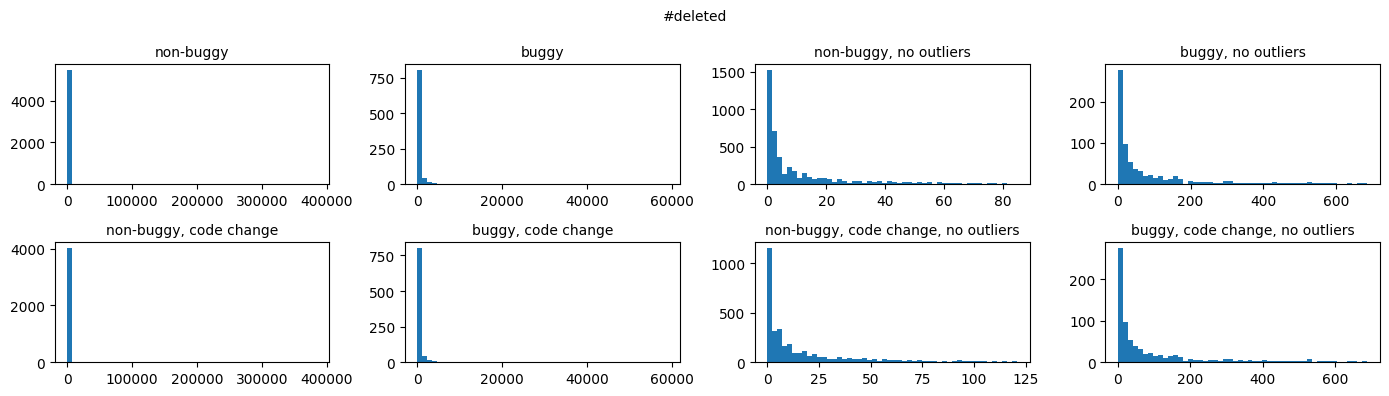

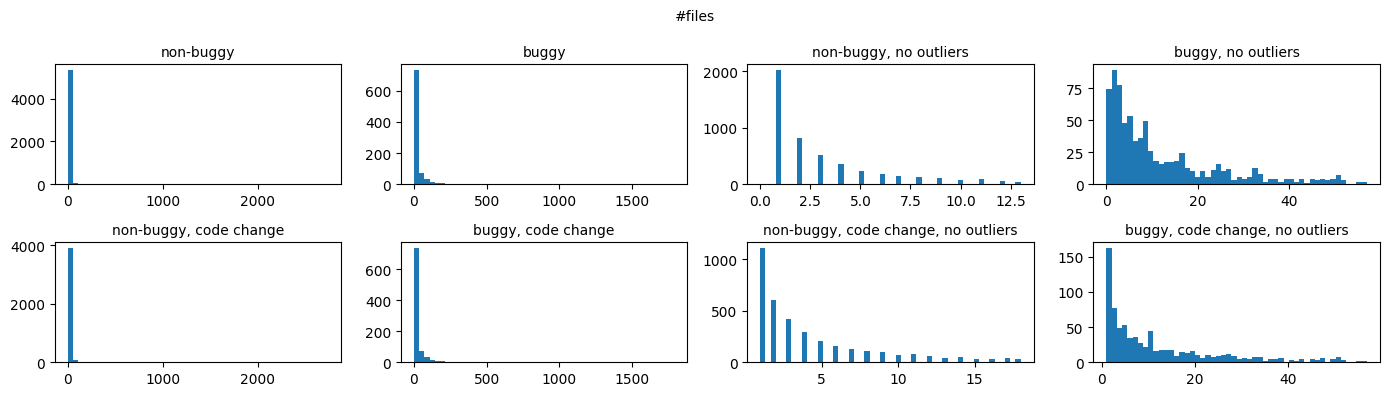

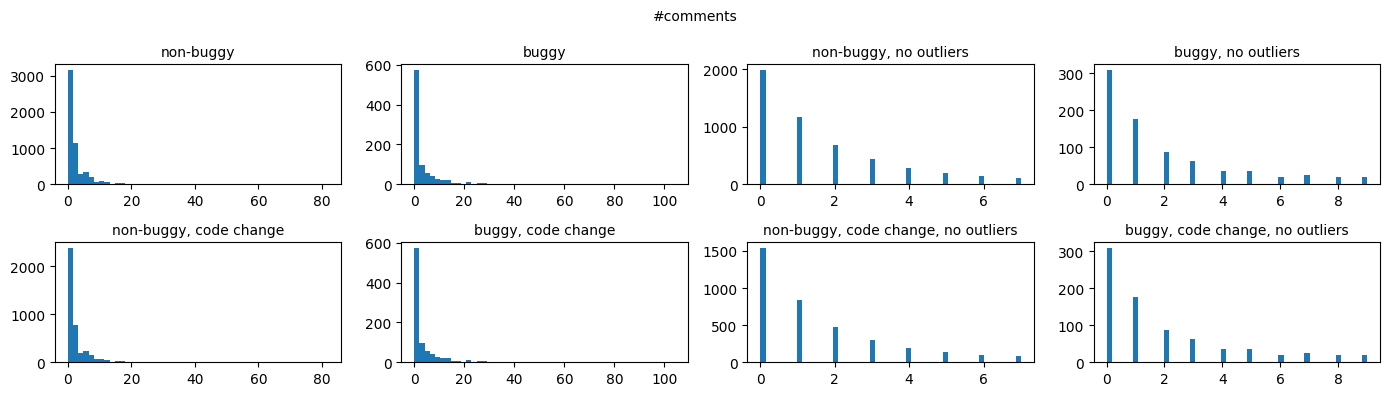

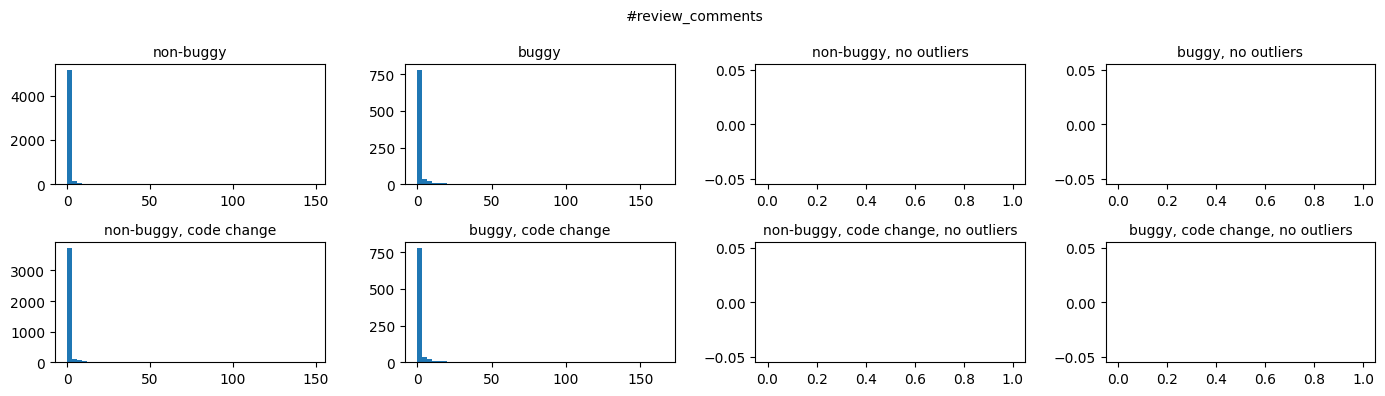

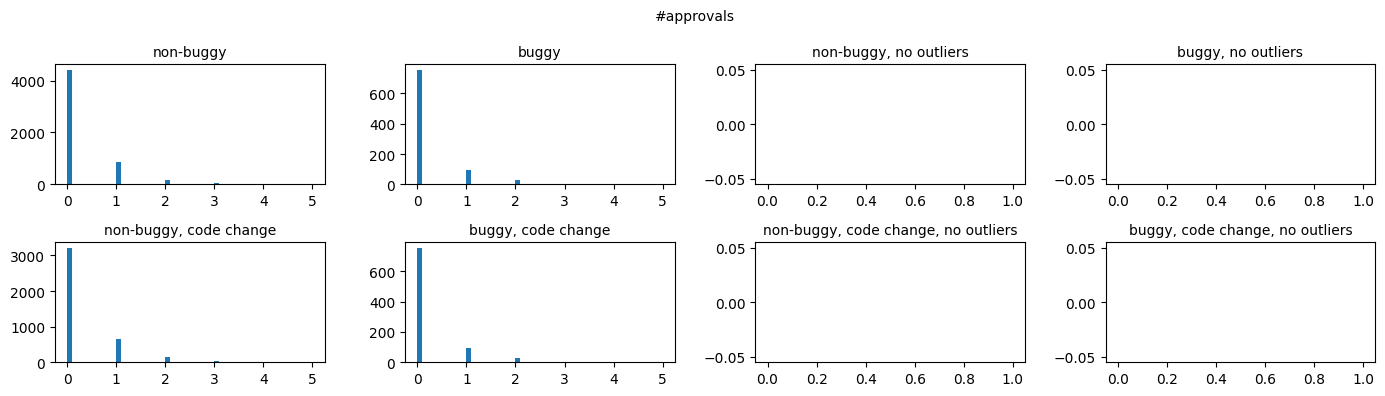

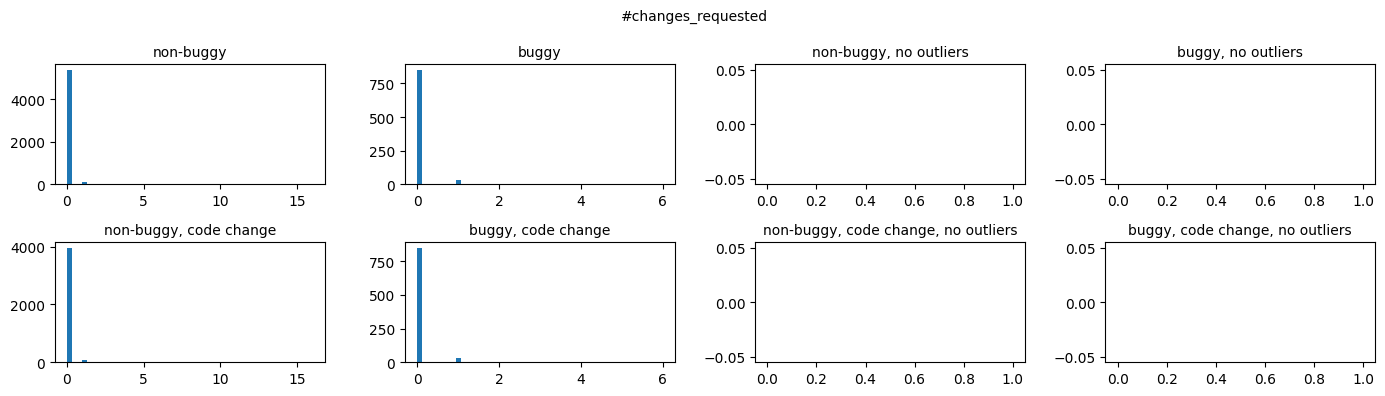

In [13]:
import matplotlib.pyplot as plt
import polars as pl

FONTSIZE = 10


def remove_outliers(series: pl.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return series.filter((series > q1 - 1.5 * iqr) & (series < q3 + 1.5 * iqr))


def plot_hist(ax, values, title):
    ax.hist(values, bins=50)
    ax.set_title(title, fontsize=FONTSIZE)


# プルリクエスト特徴量データの読み込み
df = pl.read_csv("data/pull_request_features.csv").filter(pl.col("bot") == False)
filtered_df = df.filter(pl.col("code_change") == True)

# 数値特徴量をヒストグラムにプロット
for column in df.select(pl.col(pl.Float64, pl.Int64)).columns:
    fig, ax = plt.subplots(2, 4, figsize=(14, 4))
    fig.suptitle(column, fontsize=FONTSIZE)

    # データの準備
    buggy_values = df.filter(pl.col("buggy") == True)[column]
    non_buggy_values = df.filter(pl.col("buggy") == False)[column]
    # ヒストグラム
    plot_hist(ax[0, 0], non_buggy_values, f"non-buggy")
    plot_hist(ax[0, 1], buggy_values, f"buggy")
    # 外れ値を除去したデータのヒストグラム
    plot_hist(ax[0, 2], remove_outliers(non_buggy_values), f"non-buggy, no outliers")
    plot_hist(ax[0, 3], remove_outliers(buggy_values), f"buggy, no outliers")

    # データの準備
    buggy_values = filtered_df.filter(pl.col("buggy") == True)[column]
    non_buggy_values = filtered_df.filter(pl.col("buggy") == False)[column]
    # コード変更を行っているプルリクエストのみを対象としたヒストグラム
    plot_hist(ax[1, 0], non_buggy_values, f"non-buggy, code change")
    plot_hist(ax[1, 1], buggy_values, f"buggy, code change")
    # 外れ値を除去したデータのヒストグラム
    plot_hist(
        ax[1, 2],
        remove_outliers(non_buggy_values),
        f"non-buggy, code change, no outliers",
    )
    plot_hist(
        ax[1, 3], remove_outliers(buggy_values), f"buggy, code change, no outliers"
    )

    plt.tight_layout()

# # コード変更を行っているプルリクエストに絞って，数値特徴量をヒストグラムにプロット
# df = df.filter(pl.col("code_change") == True)
# buggy_df = df.filter(pl.col("buggy") == True)
# non_buggy_df = df.filter(pl.col("buggy") == False)
# for column in df.select(pl.col(pl.Float64, pl.Int64)).columns:
#     fig, ax = plt.subplots(1, 4, figsize=(14, 2.5))
#     buggy_values = buggy_df[column]
#     non_buggy_values = non_buggy_df[column]

#     # ヒストグラム
#     ax[0].hist(non_buggy_values, bins=50)
#     ax[0].set_title(f"{column} (non-buggy)", fontsize=FONTSIZE)
#     ax[1].hist(buggy_values, bins=50)
#     ax[1].set_title(f"{column} (buggy)", fontsize=FONTSIZE)

#     # 外れ値を除去したデータのヒストグラム
#     ax[2].hist(remove_outliers(non_buggy_values), bins=50)
#     ax[2].set_title(f"{column} (non-buggy, no outliers)", fontsize=FONTSIZE)
#     ax[3].hist(remove_outliers(buggy_values), bins=50)
#     ax[3].set_title(f"{column} (buggy, no outliers)", fontsize=FONTSIZE)

#     plt.tight_layout()

### 各特徴量の箱ひげ図 (一応)

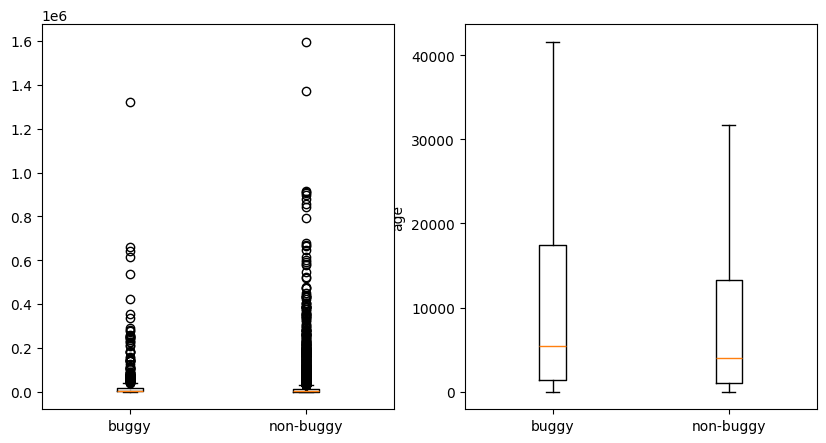

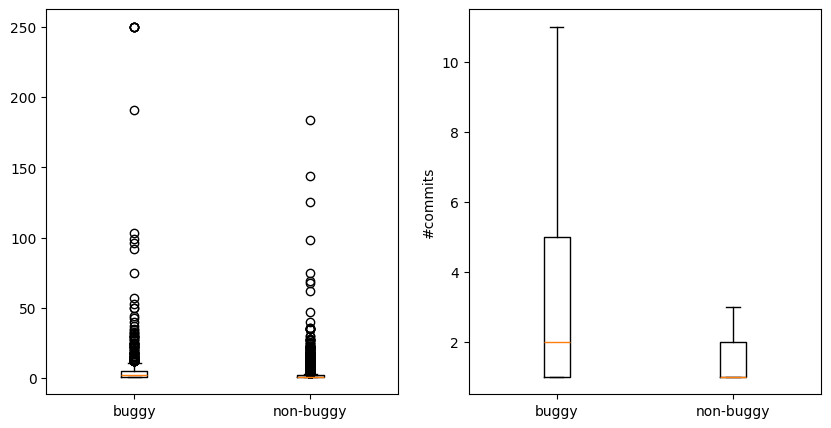

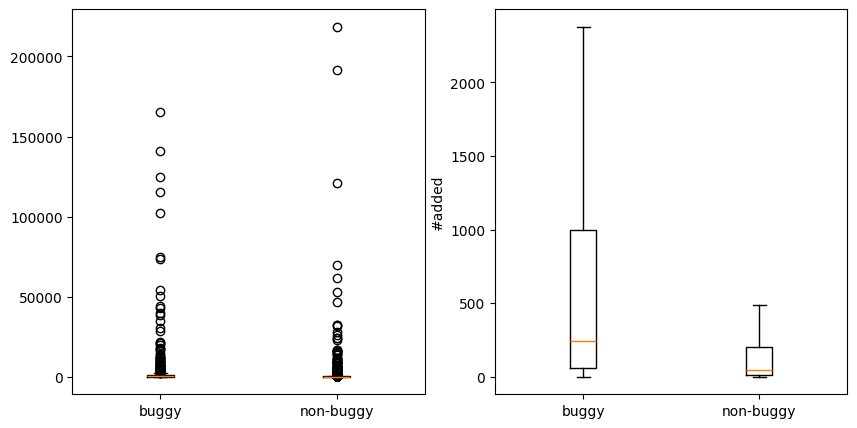

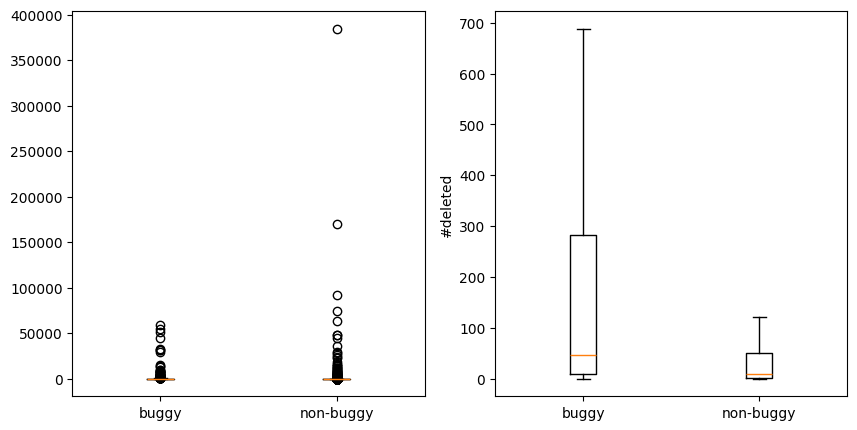

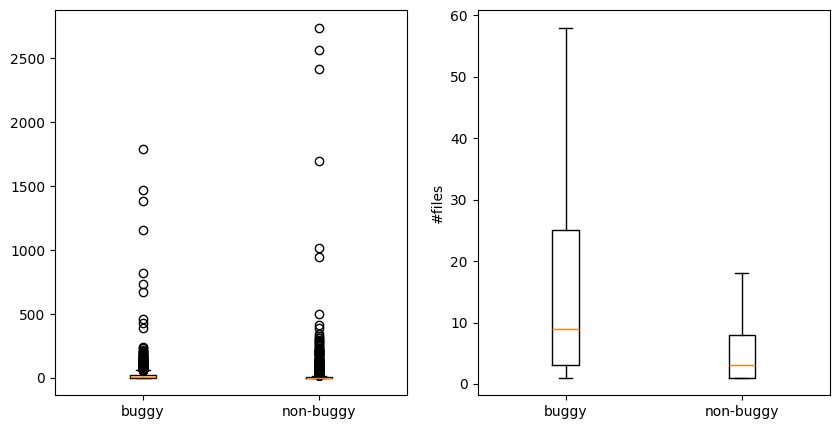

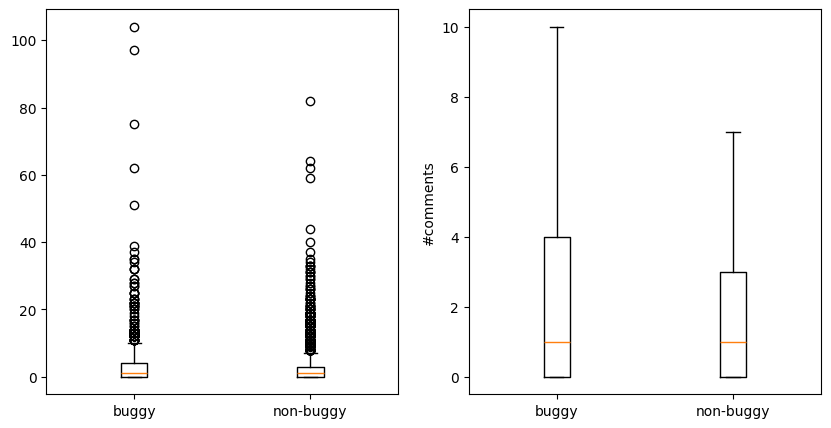

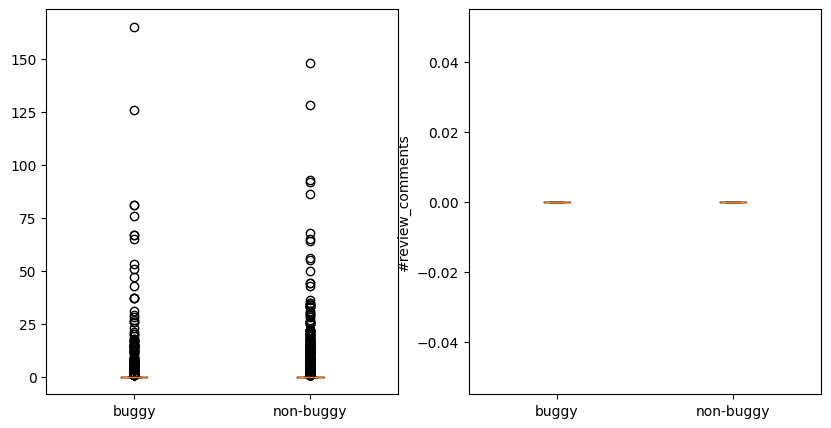

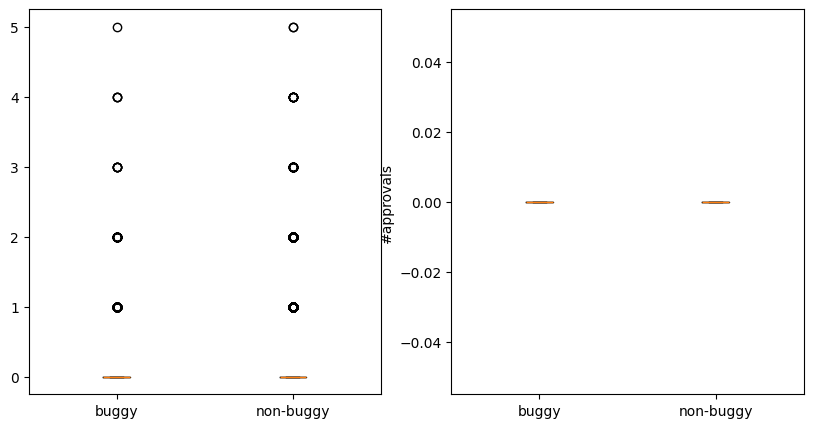

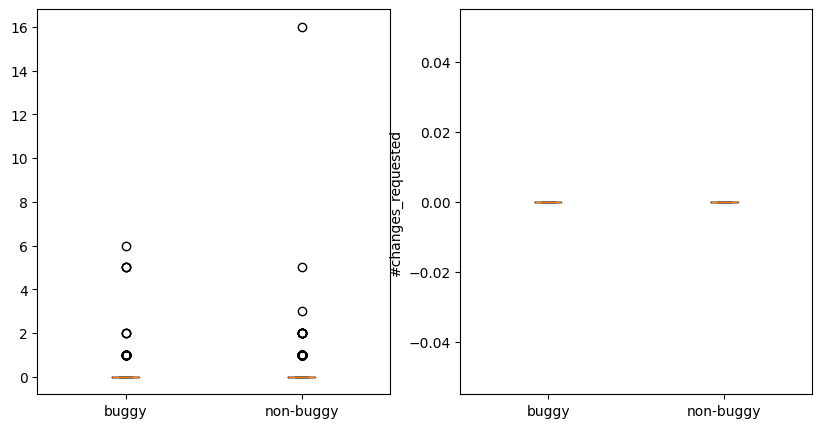

In [14]:
import matplotlib.pyplot as plt
import polars as pl

EXCLUDE_COLUMNS = ["project", "id", "url", "buggy"]

# プルリクエストの特徴量データを読み込み
df = (
    pl.read_csv("data/pull_request_features.csv")
    .filter(pl.col("bot") == False)
    .filter(pl.col("code_change") == True)
    .drop("bot")
)

# バグの有無でデータを分割
buggy_df = df.filter(pl.col("buggy") == True)
non_buggy_df = df.filter(pl.col("buggy") == False)
df = df.drop(EXCLUDE_COLUMNS)
numeric_columns = df.select(pl.col(pl.Float64), pl.col(pl.Int64)).columns
boolean_columns = df.select(pl.col(pl.Boolean)).columns

# 数値特徴量の分布を可視化
for feature in numeric_columns:
    buggy_values = buggy_df[feature]
    non_buggy_values = non_buggy_df[feature]

    # 箱ひげ図にプロット
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].boxplot(
        [buggy_values, non_buggy_values],
        tick_labels=["buggy", "non-buggy"],
        showfliers=True,
    )
    ax[1].boxplot(
        [buggy_values, non_buggy_values],
        tick_labels=["buggy", "non-buggy"],
        showfliers=False,
    )
    plt.ylabel(f"{feature}")
    plt.show()